In [ ]:
# Core libraries
import numpy as np
import pandas as pd
import os
import inspect
import json
from pathlib import Path
from IPython.display import display, HTML
import pickle
import json
# Machine learning
import xgboost as xgb
from xgboost.callback import EarlyStopping
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import (precision_score, recall_score, f1_score,
                             balanced_accuracy_score, log_loss,
                             mean_squared_error, make_scorer,
                             precision_recall_curve, confusion_matrix, matthews_corrcoef)
from sklearn.calibration import calibration_curve
from sklearn.inspection import permutation_importance

# Hyperparameter tuning
import optuna
# 1) Silence Optuna’s default trial‐completion logs
optuna.logging.set_verbosity(optuna.logging.WARNING)      # only WARN and above
optuna.logging.disable_default_handler()                   # remove the stderr handler

# Explainability
import shap
try:
    from lime.lime_tabular import LimeTabularExplainer
    _lime_available = True
except ImportError:
    _lime_available = False
    print("Warning: LIME not installed. Run `pip install lime` to enable LIME explanations.")
import lime
# Plotting
import matplotlib.pyplot as plt
import seaborn as sns

# System
import warnings
warnings.filterwarnings('ignore')

from tqdm.notebook import tqdm

class TqdmCallback:
    def __init__(self, total):
        self.bar = tqdm(total=total, desc="Trials", position=2, leave=False)
    def __call__(self, study, trial):
        self.bar.update(1)
    def close(self):
        self.bar.close()

# Constants

In [2]:
DATA_CSV      = "../data/df_2022_2024.csv"
OUT_DIR       = "../ancillary_models"

TARGETS =  [
    'Price_positive_secondary',
    'Price_negative_secondary',
    'Price_positive_tertiary',
    'Price_negative_tertiary'
]

LABEL_METHOD  = "fixed"         # {"fixed","rolling","dynamic"}
TWO_SIDED     = True              # detect negative spikes too ?
LABEL_MODE    = "binary_extreme"  # or "three_class"

P_HI, P_LO    = 90, 10
ROLL_WINDOW   = 24*7*7
K_SIGMA       = 2

N_SPLITS      = 5
N_TRIALS      = 30
# N_TRIALS      = 1
EARLY_STOP = 30
GPU_TREE      = True

# Load Data

In [3]:
#Load data
data = pd.read_csv(DATA_CSV)
data.index = pd.date_range(start='2022-11-01', periods=len(data), freq='H')

data = data.loc['2023-01-01':'2023-12-31'].copy()

# Define features
features = [col for col in data.columns if col not in TARGETS]

# Fill missing values
data.fillna(method='ffill', inplace=True)

# Label Generation

In [4]:
def make_labels(series, method=LABEL_METHOD, two_sided=TWO_SIDED, mode=LABEL_MODE,
                percentile_high=P_HI, percentile_low=P_LO, roll_window=ROLL_WINDOW, k=K_SIGMA):
    if method == "fixed":
        hi, lo = np.percentile(series, percentile_high), np.percentile(series, percentile_low)
        print(f"Fixed thresholds: hi={hi}, lo={lo}")
        up, low = series >= hi, series <= lo if two_sided else None
    elif method == "rolling":
        hi = series.rolling(roll_window).quantile(percentile_high/100)
        lo = series.rolling(roll_window).quantile(percentile_low/100)
        up, low = series >= hi, series <= lo if two_sided else None
    elif method == "dynamic":
        mu, sd = series.rolling(roll_window).mean(), series.rolling(roll_window).std()
        up, low = series >= mu+k*sd, series <= mu-k*sd if two_sided else None
    else:
        raise ValueError("method must be fixed/rolling/dynamic")

    lbl = np.where(up, 1, np.where(low, -1, 0)) if two_sided else up.astype(int)
    if mode == "binary_extreme":
        return pd.Series((lbl != 0).astype(int), index=series.index) 
    elif mode == "three_class":
        return pd.Series(lbl, index=series.index)
    else:
        raise ValueError("mode must be 'binary_extreme' or 'three_class'")

In [5]:
def make_labels(
    series: pd.Series,
    # train_window: Tuple[pd.Timestamp, pd.Timestamp],
    method: str = LABEL_METHOD,
    two_sided: bool = TWO_SIDED,
    percentile_high: float = P_HI,
    percentile_low: float  = P_LO,
    roll_window: int       = ROLL_WINDOW,
    k: float               = K_SIGMA,
    pos_floor: float       = 150,
    neg_floor: float       = 50,
    constant_high: float | None = None,
    constant_low: float | None = None,
) -> pd.Series:
    """
    Compute binary spike labels for `series`, with hi/lo thresholds
    derived *only* from the training window and floored at pos_floor / -neg_floor.

    ...
    """

    # 1) isolate training slice for threshold computation
    # t0, t1 = train_window
    # train_slice = series.loc[t0:t1]

    # 2) compute raw hi/lo
    if method == "fixed":
        hi = np.percentile(series, percentile_high)
        lo = (np.percentile(series, percentile_low)
              if two_sided else None)
        # inside label_spikes, right after computing hi and lo but before clipping:
        # print(f"  [DEBUG]  hi cutoff = {hi!r}")
        # if lo is not None:
        #     print(f"  [DEBUG]  lo cutoff = {lo!r}")


    elif method == "rolling":
        hi = series.rolling(roll_window, min_periods=1)\
                   .quantile(percentile_high / 100)
        lo = (series.rolling(roll_window, min_periods=1)
                    .quantile(percentile_low / 100)
              if two_sided else None)

    elif method == "dynamic":
        mu = series.rolling(roll_window, min_periods=1).mean()
        sd = series.rolling(roll_window, min_periods=1).std().fillna(0)
        hi = mu + k * sd
        lo = (mu - k * sd) if two_sided else None

    # elif method == "mixed":
    #     fixed_hi = np.percentile(train_slice, percentile_high)
    #     fixed_lo = (np.percentile(train_slice, percentile_low)
    #                 if two_sided else None)
    #     mu = series.rolling(roll_window, min_periods=1).mean()
    #     sd = series.rolling(roll_window, min_periods=1).std().fillna(0)
    #     dyn_hi = mu + k * sd
    #     dyn_lo = (mu - k * sd) if two_sided else None
    #     hi = dyn_hi.where(dyn_hi > fixed_hi, fixed_hi)
    #     lo = (dyn_lo.where(dyn_lo < fixed_lo, fixed_lo)
    #           if two_sided else None)
    elif method == "constant":
        if constant_high is None:
            raise ValueError("constant_high must be provided for method 'constant'")
        hi = constant_high
        lo = constant_low if (two_sided and constant_low is not None) else None

    else:
        raise ValueError(f"Unknown labeling method: {method!r}")

    if method != "constant":
        # upper floor
        if np.isscalar(hi):
            hi = max(hi, pos_floor)
        else:
            hi = hi.clip(lower=pos_floor)
        # lower floor
        if two_sided and lo is not None:
            if np.isscalar(lo):
                lo = min(lo, -neg_floor)
            else:
                lo = lo.clip(upper=-neg_floor)
                
    # 4) label spikes purely by threshold crossings
    is_high = series.ge(hi)
    if two_sided and lo is not None:
        is_low = series.le(lo)
        labels = (is_high | is_low).astype(int)
    else:
        labels = is_high.astype(int)

    return labels

## Pseudo $R^2$

In [6]:
def mc_fadden_r2(m,X,y):
    ll_full = -log_loss(y, m.predict_proba(X)[:,1], normalize=False)
    ll_null = -log_loss(y, np.full_like(y, y.mean()), normalize=False)
    return 1 - ll_full/ll_null
def tjur_r2(m,X,y):
    p = m.predict_proba(X)[:,1]
    return p[y==1].mean() - p[y==0].mean()

# Seasonal and non seasonal features

In [7]:
def add_lags(d, col, lags=(1,24,168)):
    for L in lags: d[f"{col}_lag_{L}"] = d[col].shift(L)
    return d

def add_rolls(d, col, wins=(24,168)):
    for W in wins:
        d[f"{col}_mean_{W}"] = d[col].rolling(W).mean()
        d[f"{col}_std_{W}"]  = d[col].rolling(W).std()
        d[f"{col}_max_{W}"]  = d[col].rolling(W).max()
    return d

def build_features(df, tgt):
    return add_rolls(add_lags(df.copy(), tgt), tgt).dropna()

# Parameters tuning

In [8]:
def objective(trial, X_train, y_train, X_val, y_val, ratio, gpu_tree=True):
    params = dict(
        tree_method = "gpu_hist" if gpu_tree else "hist",
        objective   = "binary:logistic",
        eval_metric = "logloss",
        learning_rate   = trial.suggest_float("lr", 0.005, 0.3, log=True),
        max_depth       = trial.suggest_int ("depth", 3, 12),
        min_child_weight= trial.suggest_int ("mcw", 1, 10),
        subsample       = trial.suggest_float("sub", 0.3, 1.0),
        colsample_bytree= trial.suggest_float("col", 0.2, 1.0),
        reg_alpha       = trial.suggest_float("alpha", 1e-3, 1),
        reg_lambda      = trial.suggest_float("lam",   1e-3, 1),
        scale_pos_weight= trial.suggest_float("spw", ratio*0.8, ratio*1.2),
        n_estimators    = trial.suggest_categorical("n", [200, 400, 800])
    )

    model = xgb.XGBClassifier(**params, early_stopping_rounds=EARLY_STOP)
    model.fit(X_train, y_train,
              eval_set=[(X_val, y_val)],
              verbose=False)
    preds = model.predict(X_val)
    mcc = matthews_corrcoef(y_val, preds)
    return mcc

# Training

### Training loop

In [9]:
def train_all_thresholds(
        method: str,                    
        two_sided: bool = True,
        label_mode: str = LABEL_MODE,
        n_splits: int = N_SPLITS,
        n_trials: int = N_TRIALS,
        gpu_tree: bool = GPU_TREE,
) -> dict:
    """Return {target: best_fold_dict} for the chosen label scheme."""

    df = data.copy()

    # If you want lags/rolling later, just uncomment build_features
    # df = add_rolls(add_lags(df), target)

    df["Date"] = pd.to_datetime(df["Date"])
    df["hour"]     = df["Date"].dt.hour
    df["weekday"]  = df["Date"].dt.weekday
    df = df.drop(columns="Date")
    df_obj = df.copy()
    best_folds = {}
    tscv       = TimeSeriesSplit(n_splits=n_splits)

    for target in tqdm(TARGETS, desc="Targets", position=0):
        df_obj = add_rolls(add_lags(df, target), target)
        X  = df_obj.drop(columns=TARGETS)
        # y  = make_labels(df_obj[target], method=method,
                        #  two_sided=two_sided, mode=label_mode)
        y  = make_labels(df_obj[target], method=method,
                            two_sided=two_sided,
                            roll_window=ROLL_WINDOW, k=K_SIGMA)
        y, X = y.align(X, join="inner", axis=0)

        folds  = []
        splits = list(tscv.split(X))

        
        # spikes = y.sum()                             
        # ratio  = np.inf if spikes == 0 else (len(y) - spikes) / spikes
        # ratio = max(1.0, min(100.0, (len(y_tr) - spikes) / spikes))  if spikes else 1.0


        for fold, (tr_idx, va_idx) in enumerate(
                tqdm(splits, desc="Folds", position=1, leave=False), start=1):

            X_tr, X_va = X.iloc[tr_idx], X.iloc[va_idx]
            y_tr, y_va = y.iloc[tr_idx], y.iloc[va_idx]
            
            spikes = int(y_tr.sum())
            ratio  = 1.0 if spikes == 0 else min(100, (len(y_tr)-spikes)/spikes)

            # Optuna search with custom tqdm callback
            study   = optuna.create_study(direction="maximize")
            pbar_cb = TqdmCallback(n_trials)
            study.optimize(
                lambda t: objective(
                    t, X_tr, y_tr, X_va, y_va, ratio, gpu_tree=gpu_tree),
                n_trials=n_trials,
                callbacks=[pbar_cb],
                show_progress_bar=False,
            )
            pbar_cb.close()

            def sanitize(params, max_depth_cap=15, spw_cap=100):
                """Keep hyper-parameters in a range XGBoost can handle."""
                params["max_depth"] = min(params.get("max_depth", 6), max_depth_cap)
                # scale_pos_weight: limit to avoid overflow when spikes=0
                spw = params.get("scale_pos_weight", 1)
                params["scale_pos_weight"] = min(spw_cap, max(1, spw))
                return params

            best_params = sanitize(study.best_trial.params)
            model = xgb.XGBClassifier(**best_params,
                                      early_stopping_rounds=EARLY_STOP)
            model.fit(X_tr, y_tr, eval_set=[(X_va, y_va)], verbose=False)

            preds = model.predict(X_va)
            folds.append({
                "fold": fold,
                "model": model,
                "X_va": X_va,
                "y_va": y_va,
                "preds": preds,
                "best_params": best_params,
                "precision": precision_score(y_va, preds, zero_division=0),
                "recall":    recall_score(y_va, preds, zero_division=0),
                "f1":        f1_score(y_va, preds,  zero_division=0),
                "confusion_matrix": confusion_matrix(y_va, preds),
                "ratio": ratio
            })

        if folds:
            best_folds[target] = max(folds, key=lambda f: f["f1"])
            print(f"Best MCC for {target} [{method}]: {best_folds[target]['f1']:.4f}")
        else:
            print(f"No valid folds for {target}.")

    return best_folds


### Train all methods

In [10]:
best_fixed    = train_all_thresholds(method="fixed")

Targets:   0%|          | 0/4 [00:00<?, ?it/s]

Folds:   0%|          | 0/5 [00:00<?, ?it/s]

Trials:   0%|          | 0/30 [00:00<?, ?it/s]

Trials:   0%|          | 0/30 [00:00<?, ?it/s]

Trials:   0%|          | 0/30 [00:00<?, ?it/s]

Trials:   0%|          | 0/30 [00:00<?, ?it/s]

Trials:   0%|          | 0/30 [00:00<?, ?it/s]

Best MCC for Price_positive_secondary [fixed]: 0.7619


Folds:   0%|          | 0/5 [00:00<?, ?it/s]

Trials:   0%|          | 0/30 [00:00<?, ?it/s]

Trials:   0%|          | 0/30 [00:00<?, ?it/s]

Trials:   0%|          | 0/30 [00:00<?, ?it/s]

Trials:   0%|          | 0/30 [00:00<?, ?it/s]

Trials:   0%|          | 0/30 [00:00<?, ?it/s]

Best MCC for Price_negative_secondary [fixed]: 0.5946


Folds:   0%|          | 0/5 [00:00<?, ?it/s]

Trials:   0%|          | 0/30 [00:00<?, ?it/s]

Trials:   0%|          | 0/30 [00:00<?, ?it/s]

Trials:   0%|          | 0/30 [00:00<?, ?it/s]

Trials:   0%|          | 0/30 [00:00<?, ?it/s]

Trials:   0%|          | 0/30 [00:00<?, ?it/s]

Best MCC for Price_positive_tertiary [fixed]: 0.6667


Folds:   0%|          | 0/5 [00:00<?, ?it/s]

Trials:   0%|          | 0/30 [00:00<?, ?it/s]

Trials:   0%|          | 0/30 [00:00<?, ?it/s]

Trials:   0%|          | 0/30 [00:00<?, ?it/s]

Trials:   0%|          | 0/30 [00:00<?, ?it/s]

Trials:   0%|          | 0/30 [00:00<?, ?it/s]

Best MCC for Price_negative_tertiary [fixed]: 0.4000


In [11]:
best_rolling  = train_all_thresholds(method="rolling")

Targets:   0%|          | 0/4 [00:00<?, ?it/s]

Folds:   0%|          | 0/5 [00:00<?, ?it/s]

Trials:   0%|          | 0/30 [00:00<?, ?it/s]

Trials:   0%|          | 0/30 [00:00<?, ?it/s]

Trials:   0%|          | 0/30 [00:00<?, ?it/s]

Trials:   0%|          | 0/30 [00:00<?, ?it/s]

Trials:   0%|          | 0/30 [00:00<?, ?it/s]

Best MCC for Price_positive_secondary [rolling]: 0.6111


Folds:   0%|          | 0/5 [00:00<?, ?it/s]

Trials:   0%|          | 0/30 [00:00<?, ?it/s]

Trials:   0%|          | 0/30 [00:00<?, ?it/s]

Trials:   0%|          | 0/30 [00:00<?, ?it/s]

Trials:   0%|          | 0/30 [00:00<?, ?it/s]

Trials:   0%|          | 0/30 [00:00<?, ?it/s]

Best MCC for Price_negative_secondary [rolling]: 0.6575


Folds:   0%|          | 0/5 [00:00<?, ?it/s]

Trials:   0%|          | 0/30 [00:00<?, ?it/s]

Trials:   0%|          | 0/30 [00:00<?, ?it/s]

Trials:   0%|          | 0/30 [00:00<?, ?it/s]

Trials:   0%|          | 0/30 [00:00<?, ?it/s]

Trials:   0%|          | 0/30 [00:00<?, ?it/s]

Best MCC for Price_positive_tertiary [rolling]: 0.5926


Folds:   0%|          | 0/5 [00:00<?, ?it/s]

Trials:   0%|          | 0/30 [00:00<?, ?it/s]

Trials:   0%|          | 0/30 [00:00<?, ?it/s]

Trials:   0%|          | 0/30 [00:00<?, ?it/s]

Trials:   0%|          | 0/30 [00:00<?, ?it/s]

Trials:   0%|          | 0/30 [00:00<?, ?it/s]

Best MCC for Price_negative_tertiary [rolling]: 0.4706


In [12]:
best_dynamic  = train_all_thresholds(method="dynamic")

Targets:   0%|          | 0/4 [00:00<?, ?it/s]

Folds:   0%|          | 0/5 [00:00<?, ?it/s]

Trials:   0%|          | 0/30 [00:00<?, ?it/s]

Trials:   0%|          | 0/30 [00:00<?, ?it/s]

Trials:   0%|          | 0/30 [00:00<?, ?it/s]

Trials:   0%|          | 0/30 [00:00<?, ?it/s]

Trials:   0%|          | 0/30 [00:00<?, ?it/s]

Best MCC for Price_positive_secondary [dynamic]: 0.6275


Folds:   0%|          | 0/5 [00:00<?, ?it/s]

Trials:   0%|          | 0/30 [00:00<?, ?it/s]

Trials:   0%|          | 0/30 [00:00<?, ?it/s]

Trials:   0%|          | 0/30 [00:00<?, ?it/s]

Trials:   0%|          | 0/30 [00:00<?, ?it/s]

Trials:   0%|          | 0/30 [00:00<?, ?it/s]

Best MCC for Price_negative_secondary [dynamic]: 0.7541


Folds:   0%|          | 0/5 [00:00<?, ?it/s]

Trials:   0%|          | 0/30 [00:00<?, ?it/s]

Trials:   0%|          | 0/30 [00:00<?, ?it/s]

Trials:   0%|          | 0/30 [00:00<?, ?it/s]

Trials:   0%|          | 0/30 [00:00<?, ?it/s]

Trials:   0%|          | 0/30 [00:00<?, ?it/s]

Best MCC for Price_positive_tertiary [dynamic]: 0.1481


Folds:   0%|          | 0/5 [00:00<?, ?it/s]

Trials:   0%|          | 0/30 [00:00<?, ?it/s]

Trials:   0%|          | 0/30 [00:00<?, ?it/s]

Trials:   0%|          | 0/30 [00:00<?, ?it/s]

Trials:   0%|          | 0/30 [00:00<?, ?it/s]

Trials:   0%|          | 0/30 [00:00<?, ?it/s]

Best MCC for Price_negative_tertiary [dynamic]: 0.2000


# Evaluation

## Helper

In [ ]:
def _safe_rmse(y_true, y_pred):
    """
    Square-root of MSE, but tolerant to old sklearn that
    didn't yet support the `squared` kw-arg.
    """
    if "squared" in inspect.signature(mean_squared_error).parameters:
        # modern sklearn (≥ 0.24) – we can ask for raw MSE
        mse = mean_squared_error(y_true, y_pred, squared=True)
    else:
        # legacy: function only returns MSE; no `squared` keyword
        mse = mean_squared_error(y_true, y_pred)
    return np.sqrt(mse)

rmse_scorer = make_scorer(_safe_rmse, greater_is_better=False)

def xgb_gain_plot(model, top=10):
    xgb.plot_importance(model.get_booster(), importance_type="gain", max_num_features=top)
    plt.title("XGBoost Gain Importance")
    plt.show()

def perm_rmse_plot(model, X_val, y_val, top=10):
    r = permutation_importance(model, X_val, y_val, scoring=rmse_scorer, n_repeats=5, random_state=0,
                               n_jobs=-1)
    idx = np.argsort(-r.importances_mean)[:top]
    plt.barh(X_val.columns[idx], -r.importances_mean[idx])
    plt.gca().invert_yaxis()
    plt.title("Permutation Importance (ΔRMSE)")
    plt.show()

def shap_plots(model, X_val):
    expl = shap.TreeExplainer(model)
    sv = expl.shap_values(X_val)
    shap.summary_plot(sv, X_val, plot_type="bar"); plt.show()
    shap.summary_plot(sv, X_val); plt.show()

def lime_local(model, X_tr, X_val, n_feat=8):
    exp = LimeTabularExplainer(
        X_tr.values,
        feature_names=X_tr.columns,
        class_names=["no_spike", "spike"],
        mode="classification",
    ).explain_instance(
        X_val.iloc[-1].values,
        model.predict_proba,
        num_features=n_feat,
    )

    # ── grab lime.css (or minimal fallback) ──
    css_path = Path(lime.__file__).with_name("lime.css")
    css = css_path.read_text() if css_path.exists() else """
        body{background:#333;color:#eee;font-family:sans-serif}
        th,td{padding:4px 8px;border:1px solid #555;font-size:12px}
        .lime{background:#1f77b4;color:#fff}
        .lime_neg{background:#ff7f0e;color:#fff}"""
    

    html = exp.as_html().replace("</head>", f"<style>{css}</style></head>")
    display(HTML(html))


def precision_recall_curve_plot(y_val, proba):
    prec, rec, _ = precision_recall_curve(y_val, proba)
    plt.plot(rec, prec)
    plt.xlabel("Recall"); plt.ylabel("Precision")
    plt.title("Precision-Recall Curve")
    plt.show()

def evaluate_model(fold_dict):
    m   = fold_dict["model"]
    Xv  = fold_dict["X_va"]
    yv  = fold_dict["y_va"]
    preds = fold_dict["preds"]

    print(f" Precision: {precision_score(yv, preds):.3f}"
          f"  Recall: {recall_score(yv, preds):.3f}"
          f"  F1: {f1_score(yv, preds):.3f}")
    print(f" BalancedAcc: {balanced_accuracy_score(yv, preds):.3f}"
          f"  McFaddenR²: {mc_fadden_r2(m, Xv, yv):.3f}"
          f"  TjurR²: {tjur_r2(m, Xv, yv):.3f}")
    xgb_gain_plot(m)
    perm_rmse_plot(m, Xv, yv)
    shap_plots(m, Xv)
    # lime_local(m, fold_dict["X_tr"], fold_dict["X_va"])
    precision_recall_curve_plot(yv, m.predict_proba(Xv)[:, 1])

def evaluate_all(best_folds: dict):
    for tgt, fld in best_folds.items():
        print(f"\n=== {tgt} ===")
        evaluate_model(fld)

## Evaluate fixed

In [14]:
# evaluate_all(best_fixed)

# Save model

## Helper

In [11]:
def _json_ready(v):
    if isinstance(v, (np.integer, np.bool_)):  return int(v)
    if isinstance(v, (np.floating,)):          return float(v)
    if isinstance(v, (np.ndarray, list, tuple)): return np.asarray(v).tolist()
    if isinstance(v, pd.Series):               return v.tolist()
    return v  

def save_best_folds(
    best_folds: dict,
    folder: str = OUT_DIR,
    tag: str | None = None            # <-- optional differentiator
) -> None:
    """
    Saves for each target:
      - <folder>/<tag>_<target>.model.json        (the XGBoost model)
      - <folder>/<tag>_<target>.metrics.json      (the metrics dict)
      - <folder>/<tag>_<target>.fold.pkl          (the entire fold dict, including X_va, y_va, preds, etc.)
    """
    os.makedirs(folder, exist_ok=True)

    for tgt, fold in best_folds.items():
        base_name = f"{tag}_{tgt}" if tag else tgt
        base_path = os.path.join(folder, base_name)

        # 1) save model JSON
        fold["model"].save_model(base_path + ".model.json")

        # 2) save metrics (everything except model, X_tr, X_va, preds)
        meta = {
            k: _json_ready(v)
            for k, v in fold.items()
            if k not in ("model", "X_tr", "X_va", "y_va", "preds")
        }
        with open(base_path + ".metrics.json", "w") as fp:
            json.dump(meta, fp, indent=2)

        # 3) pickle the rest of the fold so you can re‑evaluate later
        #    we include X_va, y_va, preds, and best_params, etc.
        to_pickle = {
            k: v
            for k, v in fold.items()
            if k in ("X_va", "y_va", "preds", "best_params", "confusion_matrix", "fold")
        }
        with open(base_path + ".fold.pkl", "wb") as fp:
            pickle.dump(to_pickle, fp, protocol=pickle.HIGHEST_PROTOCOL)

        print("✔ saved", base_name)

def load_best_folds(
        folder: str = OUT_DIR,
        tag: str | None = None
    ) -> dict:
    """
    Loads models (and their saved fold data) that match the optional `tag`.
      • tag=None    -> all files in folder
      • tag='fixed' -> only files starting with 'fixed_'
    Returns a dict mapping target -> fold_dict, where each fold_dict contains:
      - 'model'             : the loaded XGBClassifier
      - 'X_va', 'y_va'      : validation data
      - 'preds'             : saved predictions
      - 'best_params', etc. : any other meta from .metrics.json
      - 'confusion_matrix', 'fold', 'ratio', etc.
    """
    out = {}
    for fname in os.listdir(folder):
        if not fname.endswith(".model.json"):
            continue
        if tag and not fname.startswith(f"{tag}_"):
            continue

        base = fname[:-11]  # strip off ".model.json"
        # derive target name by removing tag_ if present
        tgt = base[len(tag)+1:] if tag else base

        model = xgb.XGBClassifier()
        model.load_model(os.path.join(folder, fname))

        # load metrics/meta
        with open(os.path.join(folder, base + ".metrics.json"), "r") as fp:
            meta = json.load(fp)

        # load the pickled fold data (X_va, y_va, preds, best_params, etc.)
        pkl_path = os.path.join(folder, base + ".fold.pkl")
        if os.path.exists(pkl_path):
            with open(pkl_path, "rb") as fp:
                fold_data = pickle.load(fp)
        else:
            # if you didn't pickle before, warn or skip
            fold_data = {}

        # assemble full fold dict
        fold_dict = {
            **meta,           # best_params, precision, recall, f1, confusion_matrix, ratio, fold, ...
            **fold_data,      # X_va, y_va, preds
            "model": model
        }
        out[tgt] = fold_dict

    return out

## Saving models

In [17]:
save_best_folds(best_fixed, folder=OUT_DIR, tag="fixed")
save_best_folds(best_rolling, folder=OUT_DIR, tag="rolling")
save_best_folds(best_dynamic, folder=OUT_DIR, tag="dynamic")

✔ saved fixed_Price_positive_secondary
✔ saved fixed_Price_negative_secondary
✔ saved fixed_Price_positive_tertiary
✔ saved fixed_Price_negative_tertiary
✔ saved rolling_Price_positive_secondary
✔ saved rolling_Price_negative_secondary
✔ saved rolling_Price_positive_tertiary
✔ saved rolling_Price_negative_tertiary
✔ saved dynamic_Price_positive_secondary
✔ saved dynamic_Price_negative_secondary
✔ saved dynamic_Price_positive_tertiary
✔ saved dynamic_Price_negative_tertiary


In [12]:
best_folds = load_best_folds(folder=OUT_DIR, tag="fixed")

# Model evaluation

In [13]:
def plot_spike_predictions(best_folds: dict, data: pd.DataFrame, targets: list[str]):
    """
    For each target in best_folds:
      1) Extract the validation window from the original 'data'
      2) Overlay the true spike events (y_va == 1) and predicted spikes (preds == 1)
         on the continuous price series.
    """
    # ensure Date is a datetime index
    df = data.copy()
    df["Date"] = pd.to_datetime(df["Date"])
    df = df.set_index("Date")

    for tgt in targets:
        fold = best_folds[tgt]
        X_va   = fold["X_va"]           # DataFrame, indexed by Date
        y_va   = fold["y_va"]           # Series of true labels (0/1 or -1/0/1)
        preds  = pd.Series(fold["preds"], index=y_va.index)

        # pull out the original price series over the validation window
        price_va = df[tgt].loc[y_va.index]

        plt.figure(figsize=(12, 4))
        # 1) plot the raw price
        plt.plot(price_va.index, price_va, label=f"{tgt} price")

        # 2) mark true spikes (y_va == 1)
        true_idxs = y_va[y_va == 1].index
        plt.scatter(true_idxs,
                    price_va.loc[true_idxs],
                    marker="o",
                    facecolors="none",
                    edgecolors="green",
                    label="True spikes")

        # 3) mark predicted spikes (preds == 1)
        pred_idxs = preds[preds == 1].index
        plt.scatter(pred_idxs,
                    price_va.loc[pred_idxs],
                    marker="x",
                    color="red",
                    label="Predicted spikes")

        plt.title(f"{tgt}: Actual vs. Predicted Spikes")
        plt.xlabel("Time")
        plt.ylabel("Price")
        plt.legend()
        plt.tight_layout()
        plt.show()

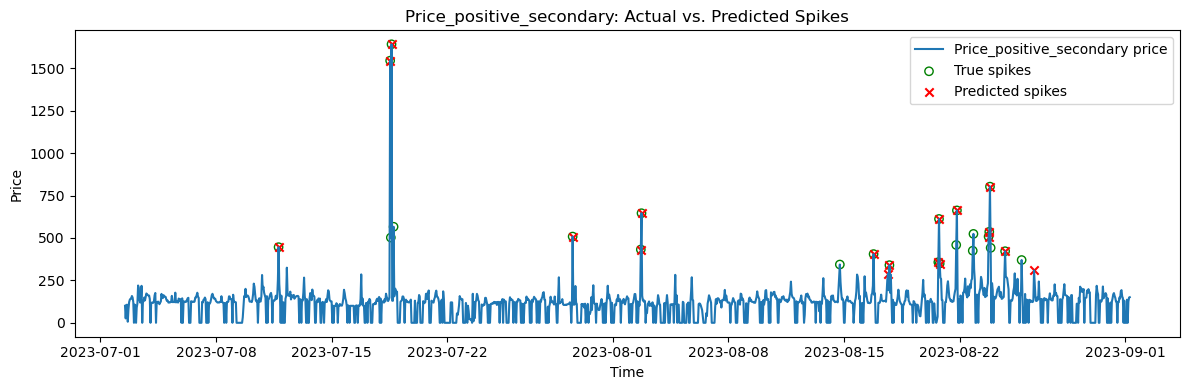

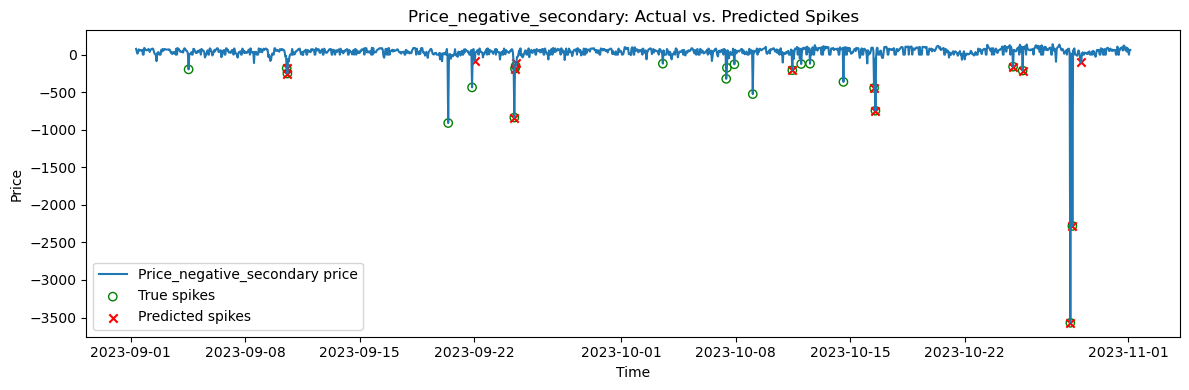

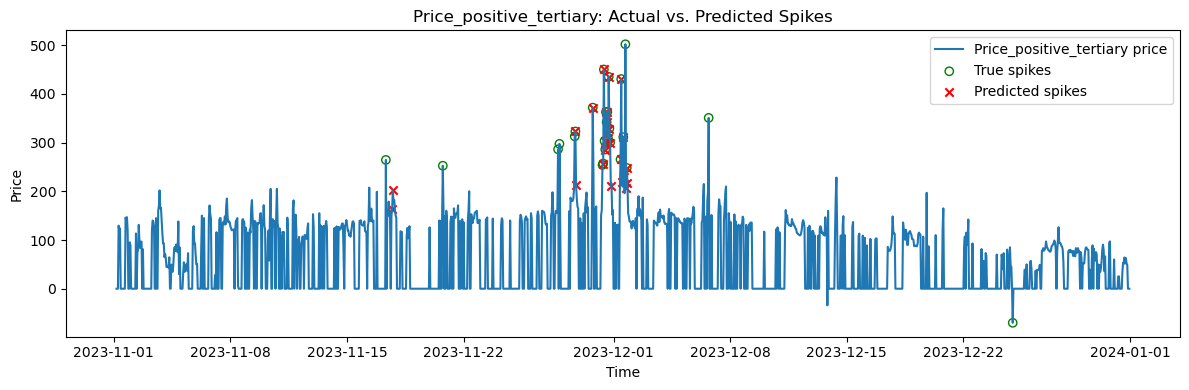

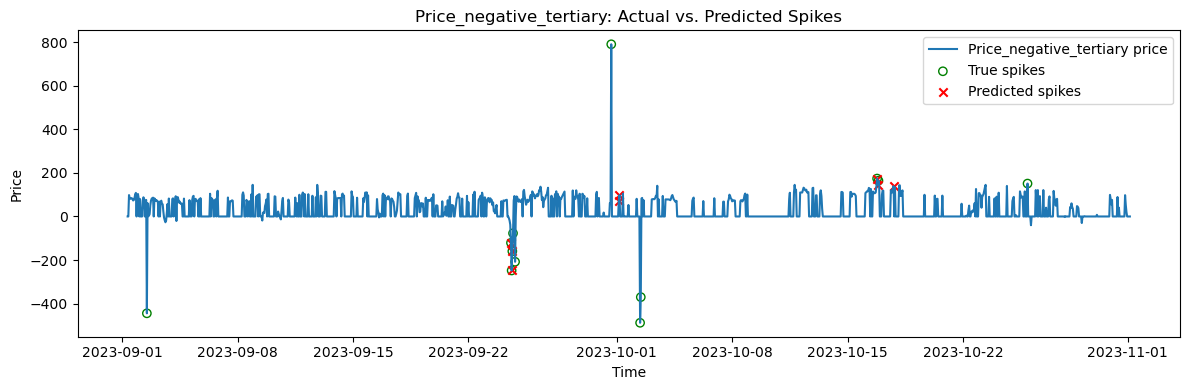

In [14]:
plot_spike_predictions(best_folds, data, TARGETS)

In [15]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

def get_thresholds(series, method='rolling', two_sided=True,
                   percentile_high=95, percentile_low=5,
                   roll_window=168, k=2):
    """Compute (hi, lo) thresholds as scalar or Series."""
    if method == "fixed":
        hi = np.percentile(series, percentile_high)
        lo = np.percentile(series, percentile_low) if two_sided else None
    elif method == "rolling":
        hi = series.rolling(roll_window).quantile(percentile_high / 100)
        lo = series.rolling(roll_window).quantile(percentile_low / 100) if two_sided else None
    elif method == "dynamic":
        mu = series.rolling(roll_window).mean()
        sd = series.rolling(roll_window).std()
        hi = mu + k * sd
        lo = mu - k * sd if two_sided else None
    elif method == "mixed":
        fixed_hi = np.percentile(series, percentile_high)
        fixed_lo = np.percentile(series, percentile_low) if two_sided else None
        mu = series.rolling(roll_window).mean()
        sd = series.rolling(roll_window).std()
        dyn_hi = mu + k * sd
        dyn_lo = mu - k * sd if two_sided else None
        hi = dyn_hi.where(dyn_hi > fixed_hi, fixed_hi)
        lo = dyn_lo.where(dyn_lo < fixed_lo, fixed_lo) if two_sided else None
    else:
        raise ValueError("Unknown method")
    return hi, lo

def plot_all_targets_with_thresholds(best_folds: dict, data: pd.DataFrame,
                                     targets: list[str],
                                     method='rolling', two_sided=True,
                                     percentile_high=95, percentile_low=5,
                                     roll_window=168, k=2,
                                     figsize=(14, 10),
                                     threshold_color='magenta',
                                     threshold_linewidth=2):
    """
    2×2 subplot of price series, thresholds, and spikes for each target.
    Lines for thresholds are colored distinctly to stand out.
    """
    df = data.copy()
    df['Date'] = pd.to_datetime(df['Date'])
    df = df.set_index('Date')

    n = len(targets)
    rows = cols = int(np.ceil(np.sqrt(n)))
    fig, axes = plt.subplots(rows, cols, figsize=figsize)
    axes = axes.flatten()

    for ax, tgt in zip(axes, targets):
        fold = best_folds[tgt]
        y_va = fold['y_va']
        preds = pd.Series(fold['preds'], index=y_va.index)
        price_va = df[tgt].loc[y_va.index]

        hi, lo = get_thresholds(price_va, method, two_sided,
                                percentile_high, percentile_low,
                                roll_window, k)

        # Plot price
        ax.plot(price_va.index, price_va, label=f'{tgt} price')

        # Plot thresholds with distinct color & thicker lines
        if isinstance(hi, (int, float)):
            ax.axhline(hi, linestyle='--', color=threshold_color,
                       linewidth=threshold_linewidth, label='High thresh')
        else:
            ax.plot(hi.index, hi, linestyle='--', color=threshold_color,
                    linewidth=threshold_linewidth, label='High thresh')
        if two_sided and lo is not None:
            if isinstance(lo, (int, float)):
                ax.axhline(lo, linestyle='--', color=threshold_color,
                           linewidth=threshold_linewidth, label='Low thresh')
            else:
                ax.plot(lo.index, lo, linestyle='--', color=threshold_color,
                        linewidth=threshold_linewidth, label='Low thresh')

        # True vs predicted spikes
        true_idxs = y_va[y_va == 1].index
        ax.scatter(true_idxs, price_va.loc[true_idxs], facecolors='none',
                   edgecolors='green', label='True spike')
        pred_idxs = preds[preds == 1].index
        ax.scatter(pred_idxs, price_va.loc[pred_idxs], marker='x',
                   color='red', label='Pred spike')

        ax.set_title(tgt)
        ax.legend(fontsize='small', loc='upper left')

    for ax in axes[n:]:
        ax.set_visible(False)

    plt.tight_layout()
    plt.show()


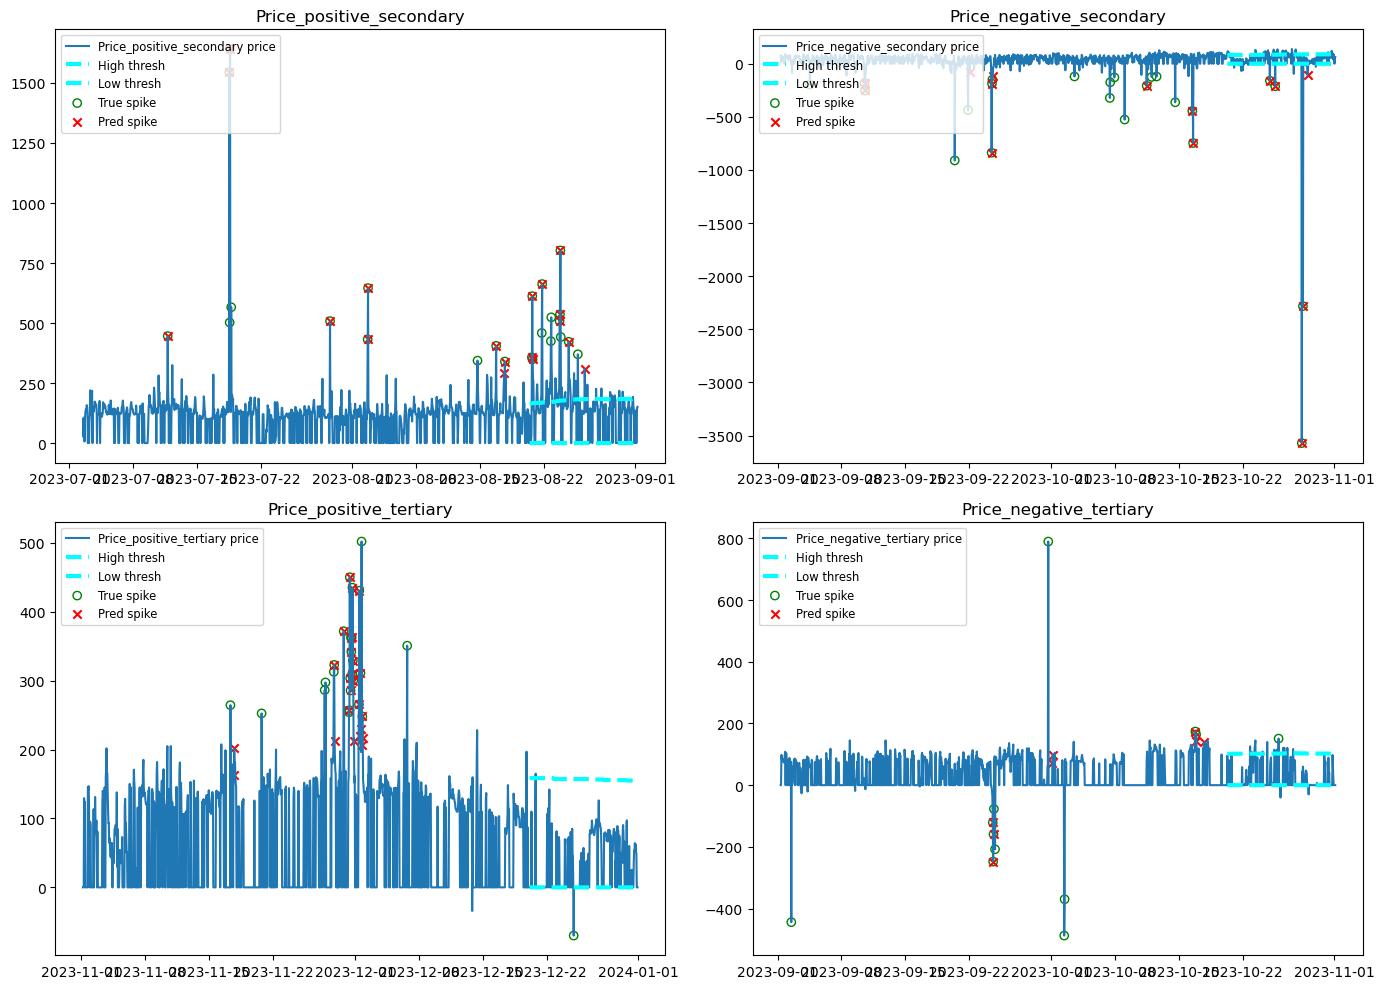

In [16]:
plot_all_targets_with_thresholds(
    best_folds, data, TARGETS,
    method='rolling', two_sided=True,
    percentile_high=P_HI, percentile_low=P_LO,
    roll_window=ROLL_WINDOW, k=K_SIGMA,
    threshold_color='cyan',
    threshold_linewidth=3
)


In [ ]:
def plot_reliability_2x2(
    folder: str = OUT_DIR,
    tag: str | None = None,
    n_bins: int = 10,
    figsize_per_plot: tuple[float, float] = (5, 4),
):
    """
    Load your best-fold models & validation splits via `load_best_folds`
    and plot a 2×2 reliability diagram (one per of the four targets).

    Raises if there are not exactly four targets.
    """
    folds = load_best_folds(folder, tag)
    targets = list(folds.keys())
    if len(targets) != 4:
        raise ValueError(f"Expected exactly 4 targets, found {len(targets)}")

    rows, cols = 2, 2
    fig, axes = plt.subplots(
        rows, cols,
        figsize=(cols * figsize_per_plot[0],
                 rows * figsize_per_plot[1]),
        squeeze=False
    )

    for idx, tgt in enumerate(targets):
        ax = axes[idx // cols][idx % cols]
        fd = folds[tgt]
        model = fd["model"]
        X_va = fd["X_va"]
        y_va = fd["y_va"]

        # get predicted probabilities for the positive class
        y_prob = model.predict_proba(X_va)[:, 1]

        # calibration curve: (fraction_of_positives, mean_predicted_value)
        prob_true, prob_pred = calibration_curve(
            y_va, y_prob, n_bins=n_bins, strategy="uniform"
        )

        ax.plot(prob_pred, prob_true, marker="o", label=tgt)
        ax.plot([0, 1], [0, 1], linestyle="--", color="gray", label="Perfect")

        ax.set_title(f"{tgt} Reliability")
        ax.set_xlabel("Mean Predicted Probability")
        ax.set_ylabel("Fraction of Positives")
        ax.legend(loc="best")
        ax.grid(True)

    fig.tight_layout()
    plt.show()

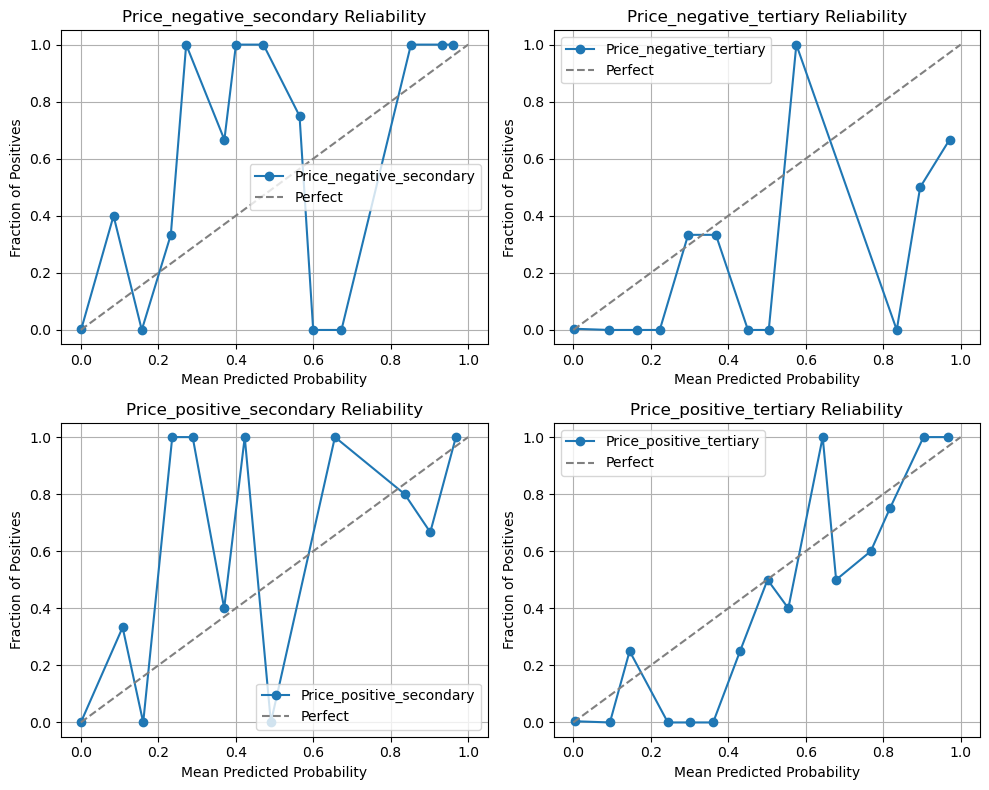

In [21]:
plot_reliability_2x2(folder=OUT_DIR, tag="fixed", n_bins=15)